### **Reference:**
1. [Rensorflow Tensorflow Object Detection 2.0](https://colab.research.google.com/drive/1sLqFKVV94wm-lglFq_0kGo2ciM0kecWD#scrollTo=gN0EUEa3e5Un&uniqifier=1)


### **Connect to my drive**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### **Install tensorflow GPU**

In [ ]:
!pip install -U --pre tensorflow_gpu==2.4.1

In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

### **Download Model**

In [ ]:
%cd /gdrive/Shareddrives/DeepLearn/1-FCNN/
%ls

/gdrive/Shareddrives/DeepLearn/1-FCNN
1M-FCNN.ipynb  dataset_1/  generate_tfrecord.py  models/  training_1/


In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
%cd /gdrive/Shareddrives/DeepLearn/1-FCNN/
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
    # pathlib.Path.cwd()
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

/gdrive/Shareddrives/DeepLearn/1-FCNN


### **Install Object Detection dependencies**

In [ ]:
# # To delete folder
# %cd /gdrive/Shareddrives/DeepLearn/1-FCNN/
# import shutil
# shutil.rmtree(r"models")

In [ ]:
# Install the Object Detection API
%%bash
cd /gdrive/Shareddrives/DeepLearn/1-FCNN/models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [ ]:
# Run this line if the TensorFlow Object Detection API has been installed (Takes about 5.14 minutes)
%cd /gdrive/Shareddrives/DeepLearn/1-FCNN/models/research/
!python -m pip install .

### **Import object etection dependencies**

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

### **Run model builder test**

In [ ]:
!python /gdrive/Shareddrives/DeepLearn/1-FCNN/models/research/object_detection/builders/model_builder_tf2_test.py

### **Generate tr.record and csv file**

In [ ]:
# Generate tf.record file
%cd /gdrive/Shareddrives/DeepLearn/1-FCNN/
!python generate_tfrecord.py -x dataset_1/train -l dataset_1/label_map.pbtxt -o dataset_1/train.record -i dataset_1/train -c dataset_1/train.csv
!python generate_tfrecord.py -x dataset_1/test -l dataset_1/label_map.pbtxt -o dataset_1/test.record -i dataset_1/test -c dataset_1/test.csv

/gdrive/Shareddrives/DeepLearn/1-FCNN
Successfully created the TFRecord file: dataset_1/train.record
Successfully created the CSV file: dataset_1/train.csv
Successfully created the TFRecord file: dataset_1/test.record
Successfully created the CSV file: dataset_1/test.csv


In [ ]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
test_record_fname = r"/gdrive/Shareddrives/DeepLearn/1-FCNN/dataset_1/test.record"
train_record_fname = r"/gdrive/Shareddrives/DeepLearn/1-FCNN/dataset_1/train.record"
label_map_pbtxt_fname = r"/gdrive/Shareddrives/DeepLearn/1-FCNN/dataset_1/label_map.pbtxt"

### **Congifure object detection model**

In [ ]:
##change chosen model to deploy different models available in the TF2 object detection zoo
MODELS_CONFIG = {
    'faster r-cnn resnet-50': {
        'model_name': 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8',
        'base_pipeline_file': 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz',
        'batch_size': 4
    },
    'faster r-cnn resnet-101': {
        'model_name': 'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8',
        'base_pipeline_file': 'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz',
        'batch_size': 16
    },
    'faster r-cnn resnet-152': {
        'model_name': 'faster_rcnn_resnet152_v1_640x640_coco17_tpu-8',
        'base_pipeline_file': 'faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.tar.gz',
        'batch_size': 16
    },
        'faster r-cnn inception-resnet-v2': {
        'model_name': 'faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8',
        'base_pipeline_file': 'faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8.tar.gz',
        'batch_size': 16
    }
}

#in this tutorial we implement the lightweight, smallest state of the art efficientdet model
#if you want to scale up tot larger efficientdet models you will likely need more compute!
chosen_model = 'faster r-cnn resnet-50'

num_steps = 3000 #The more steps, the longer the training. Increase if your loss function is still decreasing and validation metrics are increasing. 
num_eval_steps = 500 #Perform evaluation after so many steps

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']
batch_size = MODELS_CONFIG[chosen_model]['batch_size'] #if you can fit a large batch in memory, it may speed up your training

###### **Download pre-trained weights**

In [ ]:
%mkdir /gdrive/Shareddrives/DeepLearn/1-FCNN/models/research/deploy/fcnn_resnet
%cd  /gdrive/Shareddrives/DeepLearn/1-FCNN/models/research/deploy/fcnn_resnet
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint

!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

###### **Download model configuration (pipeline) file**

In [ ]:
%cd /gdrive/Shareddrives/DeepLearn/1-FCNN/models/research/deploy/fcnn_resnet
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

###### **Write into pipeline config file**

In [ ]:
#prepare
pipeline_fname = r"/gdrive/Shareddrives/DeepLearn/1-FCNN/models/research/deploy/fcnn_resnet/" + base_pipeline_file
fine_tune_checkpoint = r"/gdrive/Shareddrives/DeepLearn/1-FCNN/models/research/deploy/fcnn_resnet/" + model_name + '/checkpoint/ckpt-0'
min_img_dimension_config = 640
max_img_dimension_config = 1042

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)

In [ ]:
#write custom configuration file by slotting our dataset, model checkpoint, and training parameters into the base pipeline file

import re

%cd /gdrive/Shareddrives/DeepLearn/1-FCNN/models/research/deploy/fcnn_resnet/
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file_'+ model_name +'.config', 'w') as f:

    # resize image
    s = re.sub('min_dimension: [0-9]+',
               'min_dimension: {}'.format(min_img_dimension_config), s)
    s = re.sub('max_dimension: [0-9]+',
               'max_dimension: {}'.format(max_img_dimension_config), s)
   
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    
    #fine-tune checkpoint type
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
        
    f.write(s)

/gdrive/Shareddrives/DeepLearn/1-FCNN/models/research/deploy/fcnn_resnet
writing custom configuration file


In [45]:
%cat /gdrive/Shareddrives/DeepLearn/1-FCNN/models/research/deploy/fcnn_resnet/pipeline_file_faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.config

# Faster R-CNN with Resnet-50 (v1) with 640x640 input resolution
# Trained on COCO, initialized from Imagenet classification checkpoint
#
# Train on TPU-8
#
# Achieves 29.3 mAP on COCO17 Val

model {
  faster_rcnn {
    num_classes: 2
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 640
        max_dimension: 1042
        pad_to_max_dimension: true
      }
    }
    feature_extractor {
      type: 'faster_rcnn_resnet50_keras'
      batch_norm_trainable: true
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0


In [ ]:
pipeline_file = r"/gdrive/Shareddrives/DeepLearn/1-FCNN/models/research/deploy/fcnn_resnet/pipeline_file_faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.config"
model_dir = r"/gdrive/Shareddrives/DeepLearn/1-FCNN/training_1"

### **Train my custom model**

In [ ]:
# Check GPU type
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [ ]:
# START TRAINING...
!python /gdrive/Shareddrives/DeepLearn/1-FCNN/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

2021-04-22 05:55:07.796897: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-04-22 05:55:10.653461: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-22 05:55:10.654526: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-22 05:55:10.664008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-22 05:55:10.664716: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-04-22 05:55:10.664751: I tensorflow/stream_executor/platform/defau

### **Run model evaluation to obtain performance metrics**

In [ ]:
#run model evaluation to obtain performance metrics
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --checkpoint_dir={model_dir} \
# Not yet implemented for EfficientDet

### **Load TensorBoard**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/gdrive/Shareddrives/DeepLearn/1-FCNN/training_1/train'

<IPython.core.display.Javascript object>

### **Run conversion script**

In [ ]:
#see where our model saved weights
%ls '/gdrive/Shareddrives/DeepLearn/1-FCNN/training_1/'

In [ ]:
#run conversion script
import re
import numpy as np

output_directory = '/gdrive/Shareddrives/DeepLearn/1-FCNN/fine_tuned_model_1'

#place the model weights you would like to export here
last_model_path = '/gdrive/Shareddrives/DeepLearn/1-FCNN/training_1/'
print(last_model_path)
!python /gdrive/Shareddrives/DeepLearn/1-FCNN/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

In [ ]:
# Check saved models
%ls '/gdrive/Shareddrives/DeepLearn/1-FCNN/fine_tuned_model_1'

### **Load Deendencies and Function before testing model**

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import cv2

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


def load_image_into_numpy_array_2(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))




### **Run Inference on Test Images with Custom TensorFlow2 Object Detector**

In [ ]:
%cd /gdrive/Shareddrives/DeepLearn/1-FCNN/dataset_1/test/
%ls '/gdrive/Shareddrives/DeepLearn/1-FCNN/training_1/'

###### **Load trained model from checkpoint**

In [ ]:
import pathlib

filenames = list(pathlib.Path('/gdrive/Shareddrives/DeepLearn/1-FCNN/training_1/').glob('*.index'))

# filenames.sort()
print(filenames)

#recover our saved model
pipeline_config = pipeline_file   
#generally you want to put the last ckpt from training in here
model_dir = str(filenames[-1]).replace('.index','')    # /gdrive/Shareddrives/DeepLearn/1-FCNN/training_1/ckpt-15
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [ ]:
#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

###### **Use model to predict**

/gdrive/Shareddrives/DeepLearn/1-FCNN/dataset_1/test/fifty_1.jpg


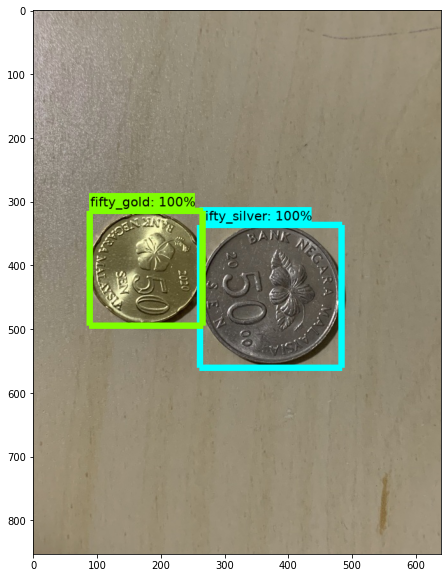

In [46]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random

TEST_IMAGE_PATHS = glob.glob('/gdrive/Shareddrives/DeepLearn/1-FCNN/dataset_1/test/*.jpg')
image_path = random.choice(TEST_IMAGE_PATHS)
image_np = load_image_into_numpy_array('/gdrive/Shareddrives/DeepLearn/1-FCNN/dataset_1/test/fifty_4.jpg')
print(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      fontsize=20,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.9,
      agnostic_mode=False,
      line_thickness=10)

plt.figure(figsize=(15,10))
plt.imshow(image_np_with_detections)
plt.show()